In [438]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [439]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [440]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [441]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

DATA_DIR = 'data'
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [442]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [443]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [444]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [445]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [446]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [447]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [448]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\dolzh\AppData\Local\Temp\ipykernel_4996\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [449]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Отсюда начнем преобразования

Работа с признаком адреса

In [450]:
# функция выделения из текста города
def adress_analysis(text):
    if text.split()[-1] == 'Kingdom':
        city = text.split()[-5]
        country = ' '.join(text.split()[-2:])
    else:
        city = text.split()[-2]
        country = text.split()[-1]
    return city

# создаем признак города
data['city'] = data['hotel_address'].apply(adress_analysis)

# удаляем признак адреса
data = data.drop(columns=['hotel_address'])

Кодируем признак названия и удаляем его

In [451]:
# для признака названия отеля производим двоичную кодировку
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

# удаляем признак названия отеля
data = data.drop(columns=['hotel_name'])

Кодируем признак национальности и удаляем его

In [452]:
# убираем лишние пробелы из элементов признака
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip().lower())
# создаем список из 10 наиболее часто встречающихся национальностей
most_common_nations = data['reviewer_nationality'].value_counts(normalize=True)[:10].index.tolist()
# оставляем только национальности из списка, остальные Other
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in most_common_nations else 'other')

# применяем однократное кодирование для признака (11 признаков)
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

# удаляем исходный признак национальности
data = data.drop(columns=['reviewer_nationality'])

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


кодируем признак города

In [453]:
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)

# удаляем исходный признак национальности
data = data.drop(columns=['city'])

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


Действия выше --- MAPE: 0.1387163072970709

Пропуски только в столбцах с широтой и долготой. Если в строке пропуск, удаляем строку

Работа с негативными отзывами

In [454]:
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
# список взят из (https://www.kaggle.com/code/motoborgrus/proj-3-data/notebook#%D0%9F%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA-hotel_address)
no_negative_review = ['No Negative', 'Nothing', 'nothing', 'None', 'N A', '',
 'Nothing really', 'N a', 'All good', 'No complaints', 'Nothing at all', 'Nothing to dislike',
 'none', 'Nil', 'Everything was perfect', 'Can t think of anything', 'n a', 'Absolutely nothing',
 'Everything was great', 'Nothing to complain about', 'Nothing not to like', 'NA', 'I liked everything',
 'NOTHING', 'No', 'Everything was good', 'Liked everything', 'Not much', 'Nothing all good', 'Nothing in particular',
 'Everything was fine', 'Na', 'All was good', 'Nothing it was perfect', 'Non', 'Nothing comes to mind', 'There was nothing I didn t like',
 'No complaints at all', 'Nothing everything was perfect', 'We liked everything', 'Nothing I didn t like', 'No negatives', 'There was nothing to dislike',
 'Nothing everything was great', 'nothing really', 'Nothing to report', 'Not a thing', 'It was all good', 'There was nothing we didn t like',
 'Loved everything', 'No thing', 'no complaints', 'All ok', 'all good', 'There was nothing not to like', 'No issues', 'Nothing I can think of', 'No bad experience',
 'Nothing to say', 'No dislikes', 'Nothing to mention', 'no', 'Everything was excellent', 'Nothing we didn t like', 'No problems', 'Nothing to complain',
 'Nada', 'Nothing bad to say', 'everything', 'nil', 'nothing at all', 'I loved everything', 'Nothing bad', 'All great']

no_negative_review = [i.lower() for i in no_negative_review]
data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_review else 1)
data = data.drop(columns=['negative_review'])

Работа с позитивными отзывами

In [455]:
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())
no_positive_review = ['no positive', 'nothing', 'n a', 'none', '', ' ' , 'not much', 'nothing at all']
data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_review else 1)
data = data.drop(columns=['positive_review'])

Перевод признака даты в количество дней

In [456]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['days_from_rewiew'] = (data['review_date'].max() - data['review_date']).dt.days
# удаляем признак даты и признак days since rewiew, т.к. дублируется
data = data.drop(columns=['review_date'])
data = data.drop(columns=['days_since_review'])

Пропуски только в столбцах с широтой и долготой. Если в строке пропуск, удаляем строку

In [457]:
# data = data.dropna(how='any', axis=0)

# data['lat'] = data['lat'].fillna(0, inplace=True)
# data['lng'] = data['lng'].fillna(0, inplace=True)
data = data.drop(columns=['lat', 'lng'])

Удалим дубликаты

In [458]:
# не удалим, т.к. если удаляем то в последней ячейке - ошибка
# data = data.drop_duplicates()

Действия выше --- MAPE: 0.13401346221707813

#### Создание новых признаков (из признака tags)

In [459]:
# функция перевода текста тегов в список
def tags_to_list(text):
    # list_len = len(text[2:-2].split('\', \''))
    tag_list = text[2:-2].split('\', \'')
    tag_list = [i.strip().lower() for i in tag_list]
    return tag_list

data['tags'] = data['tags'].apply(tags_to_list)

In [460]:
tags = []
for tag_list in data['tags']:
    for tag in tag_list:
        tags.append(tag)
        
from collections import Counter
cnt = Counter(tags)
# cnt.most_common()

In [461]:
for i in cnt.most_common():
    if i[1] > 2000 and 'night' not in i[0]:
        feature = i[0]
        data[feature] = data['tags'].apply(lambda x: 1 if feature in x else 0)

In [462]:
# определение количества ночей
# определяем из списка тегов тег с количеством ночей
def nights_in_hotel(tags_list):
    
    for tag in tags_list:
        if 'night' in tag:
            for i in tag.split():
                if i.isdigit():
                    return i
    return np.NaN
# применяем функцию, получаем признак в строковом формате, внутри которого число (присутствуют пропуски)
data['nights_in_hotel'] = data['tags'].apply(nights_in_hotel)
# заполняем пропуски модой
data['nights_in_hotel'] = data['nights_in_hotel'].fillna(data['nights_in_hotel'].mode()[0])
# приводим к типу int
data['nights_in_hotel'] = data['nights_in_hotel'].astype('int')

# удаляем признак тега
data = data.drop(columns=['tags'])

Действия выше --- MAPE: 0.13286838323392136

In [463]:
data.nunique(dropna=False)

additional_number_of_scoring          480
average_score                          34
review_total_negative_word_counts     402
total_number_of_reviews              1142
review_total_positive_word_counts     365
                                     ... 
classic twin room                       2
twin guest room                         2
family room                             2
travelers with friends                  2
nights_in_hotel                        31
Length: 94, dtype: int64

<AxesSubplot:>

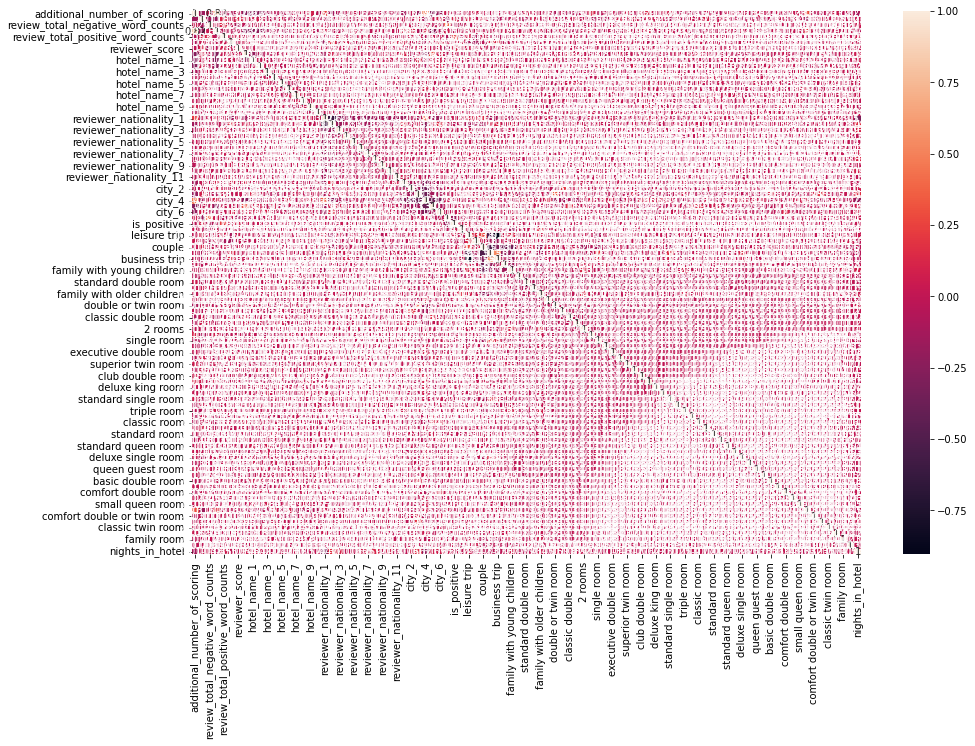

In [464]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [465]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [466]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 94 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   hotel_name_0                                515738 non-null  int64  
 9   hotel_name_1                                515738 non-null  int64  
 

In [467]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [468]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [469]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 93), (386803, 93), (386803, 92), (309442, 92), (77361, 92))

In [470]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [471]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [472]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


In [473]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13293445481080088


<AxesSubplot:>

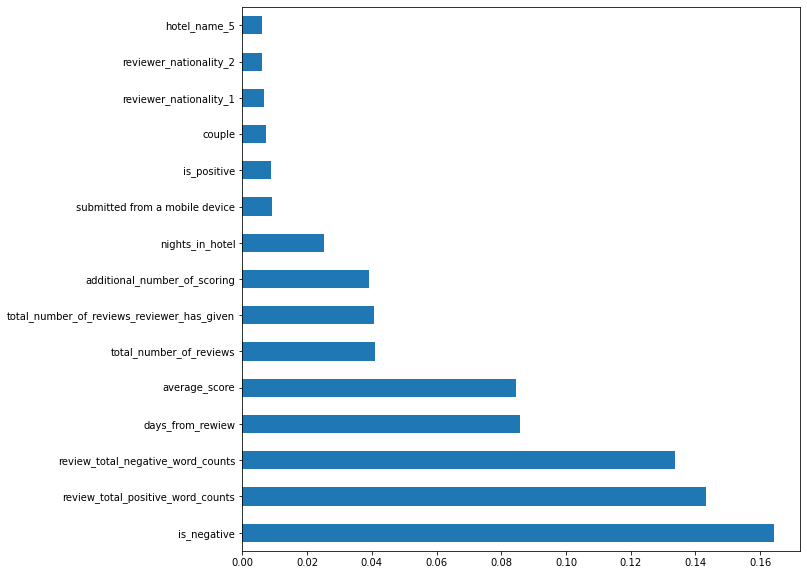

In [474]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [475]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_name_0,hotel_name_1,hotel_name_2,...,executive king room,small queen room,standard double room without window,comfort double or twin room,double or twin room 1 2 adults,classic twin room,twin guest room,family room,travelers with friends,nights_in_hotel
15308,681,8.9,0,2692,33,6,0.0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
64966,1444,7.8,10,5726,7,2,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16148,79,8.5,0,596,16,1,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
44128,50,9.1,0,560,9,3,0.0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
12598,40,9.3,0,252,32,7,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
115230,162,8.6,28,2286,32,15,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
115185,256,9.1,6,949,16,2,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
96424,493,9.0,10,4192,5,1,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
111612,854,7.8,35,3867,37,15,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
96402,879,8.8,21,2768,37,5,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [476]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [477]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [478]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


In [479]:
predict_submission

array([8.915, 6.855, 8.062, ..., 7.813, 9.476, 6.899])

In [480]:
list(sample_submission)

['reviewer_score', 'id']

In [481]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.915,488440
1,6.855,274649
2,8.062,374688
3,9.671,404352
4,9.391,451596
5,8.305,302161
6,6.567,317079
7,7.777,13963
8,8.793,159785
9,7.842,195089
